# Setup

In [1]:

# import libraries

import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.cluster import KMeans



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import metrics



from sklearn.cluster import KMeans

2023-11-29 02:28:33.165562: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# set display settings

warnings.simplefilter(action='ignore', category=RuntimeWarning)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)

# Import Tabular Data and Define Column Groups

In [3]:
# specify columns and datatypes, load full consolidated sdss dataset, and create class map

# load column names from file into a list
sdss_headers = pd.read_csv('../data/processed/sdss_full.csv.gz', compression='gzip', header=0, index_col=0, nrows=0).columns.tolist()

# specify column groups
object_identifiers = ['dr8objid']
galaxy_identifiers = ['gz2_filenumber']
object_locations = ['ra', 'dec']
class_label_names = ['sdss_clean_class_name', 'stellar_subclass_MK', 'gz2_subclass_hubble']
class_label_codes = ['sdss_clean_class_code', 'stellar_subclass_code', 'gz2_subclass_code']
galaxy_binary_labels = [label for label in sdss_headers if 'flag' in label]
galaxy_filters = ['petroR90_r_log']
object_features = ['redshift_log', 'sum_p', 'u-r_p', 'g-i_p', 'r-z_p']
star_features = ['elodie_color_index', 'elodie_temperature', 'elodie_metallicity']
# consider adding galaxy features:  ratio of petro_radius to petro_brightness

# create a datatype dictionary for object_identifiers
col_dtypes = {col: 'string' for col in object_identifiers + galaxy_identifiers}

# load full consolidated sdss dataset
sdss_primary = pd.read_csv('../data/processed/sdss_primary.csv.gz', compression='gzip', header=0, dtype=col_dtypes)

# create map between class label codes and class label names
sdss_clean_class_map = dict(zip(sdss_primary[class_label_names[0]], sdss_primary[class_label_codes[0]]))
stellar_subclass_map = dict(zip(sdss_primary[class_label_names[1]], sdss_primary[class_label_codes[1]]))
gz2_subclass_map = dict(zip(sdss_primary[class_label_names[2]], sdss_primary[class_label_codes[2]]))
class_code_maps = [sdss_clean_class_map, stellar_subclass_map, gz2_subclass_map]

/tmp/ipykernel_7747/1582399338.py:22: DtypeWarning: Columns (10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  sdss_primary = pd.read_csv('../data/processed/sdss_primary.csv.gz', compression='gzip', header=0, dtype=col_dtypes)


# EDA - Investigate Classes and Features in Tabular Data

### Define and Call Helper Functions

In [4]:
# inspect the imported data

""" # display some data
display(sdss_primary.head(3))
display(sdss_primary.tail(3))
display(sdss_primary.sample(10))"""
 
# inspect dataframe
"""print(sdss_primary.shape)
print(sdss_primary.info())"""

'print(sdss_primary.shape)\nprint(sdss_primary.info())'

In [5]:
"""# investigate superclasses & simplified subclasses (categorical label names)

# create a helper function for investigating and plotting a subset from a column w/ categorical data
def investigate_clean_classes(df, column, filter=None):
    data = df[column]
    if filter:
        data = df[df['sdss_clean_class_name'] == filter][column]
    unclassified_count = data.isna().sum() + (data == 'unclassified').sum() + (data == 'unkonwn').sum()
    print(f"\n---------- {column} : {filter} ----------")
    print(f"The number of rows with classified values is: {len(data) - unclassified_count}")
    print(f"The number of unique labels is: {len(df[column].unique())}")
    data2 = data[data != 'unclassified']
    data2 = data2[data2 != 'unknown']
    plt.figure(figsize=(3, 2))
    sns.countplot(y=data2, order=data2.value_counts().index[:15], palette='viridis')
    #plt.suptitle(f"{column = }")
    #plt.tight_layout()
    plt.show()

investigate_clean_classes(sdss_primary, 'sdss_clean_class_name')
investigate_clean_classes(sdss_primary, 'gz2_subclass_hubble', 'galaxy')
investigate_clean_classes(sdss_primary, 'stellar_subclass_MK', 'star')"""

'# investigate superclasses & simplified subclasses (categorical label names)\n\n# create a helper function for investigating and plotting a subset from a column w/ categorical data\ndef investigate_clean_classes(df, column, filter=None):\n    data = df[column]\n    if filter:\n        data = df[df[\'sdss_clean_class_name\'] == filter][column]\n    unclassified_count = data.isna().sum() + (data == \'unclassified\').sum() + (data == \'unkonwn\').sum()\n    print(f"\n---------- {column} : {filter} ----------")\n    print(f"The number of rows with classified values is: {len(data) - unclassified_count}")\n    print(f"The number of unique labels is: {len(df[column].unique())}")\n    data2 = data[data != \'unclassified\']\n    data2 = data2[data2 != \'unknown\']\n    plt.figure(figsize=(3, 2))\n    sns.countplot(y=data2, order=data2.value_counts().index[:15], palette=\'viridis\')\n    #plt.suptitle(f"{column = }")\n    #plt.tight_layout()\n    plt.show()\n\ninvestigate_clean_classes(sdss_pri

In [6]:
"""# investigate histograms of feature columns, color-shaded by superclass

# generate a subset dataframe
df = sdss_primary[['sdss_clean_class_name'] + object_features + star_features]
df = df.sample(frac=0.5)

# define classes
classes = sdss_primary['sdss_clean_class_name'].unique()

# set a color palette with distinct colors for each category
colors = sns.color_palette('bright', n_colors=len(df['sdss_clean_class_name'].unique()))

# iterate over columns and create separate plots
for col in object_features + star_features:
    plt.figure(figsize=(3, 2))
    plt.xscale('linear')
    log_choice = False
    denom = df[col].min()
    if denom == 0:
        denom = 0.001
    if abs(df[col].max() / denom) > 50:
        df[col] = df[col].replace(0, 0.001)
        log_choice = True
        plt.xscale('symlog')  
    for class_label, color in zip(classes, colors):
        if 'elodie' in col:
            if class_label == 'star':
                sns.histplot(df[df['sdss_clean_class_name'] == class_label][col], bins=25, label=class_label, log_scale=log_choice)
        else:
            sns.histplot(df[df['sdss_clean_class_name'] == class_label][col], bins=25, label=class_label, log_scale=log_choice)
    plt.title(col)
    plt.legend()
    plt.show()"""

"# investigate histograms of feature columns, color-shaded by superclass\n\n# generate a subset dataframe\ndf = sdss_primary[['sdss_clean_class_name'] + object_features + star_features]\ndf = df.sample(frac=0.5)\n\n# define classes\nclasses = sdss_primary['sdss_clean_class_name'].unique()\n\n# set a color palette with distinct colors for each category\ncolors = sns.color_palette('bright', n_colors=len(df['sdss_clean_class_name'].unique()))\n\n# iterate over columns and create separate plots\nfor col in object_features + star_features:\n    plt.figure(figsize=(3, 2))\n    plt.xscale('linear')\n    log_choice = False\n    denom = df[col].min()\n    if denom == 0:\n        denom = 0.001\n    if abs(df[col].max() / denom) > 50:\n        df[col] = df[col].replace(0, 0.001)\n        log_choice = True\n        plt.xscale('symlog')  \n    for class_label, color in zip(classes, colors):\n        if 'elodie' in col:\n            if class_label == 'star':\n                sns.histplot(df[df['sdss

# Define Helper Functions for Tabular Data

In [7]:
# define a helper function to extract only objects of interest, given a specified set of classes

def jsm_specify_objects(objects='superclass', min_set_size=1000):
    
    # return secondary dataset containing only defined objects
    if objects == 'superclass':
        class_code_column = class_label_codes[0:1] #'sdss_clean_class_code'
        class_name_column  = class_label_names[0]
    elif objects == 'stars':
        class_code_column = class_label_codes[1:2] #'stellar_subclass_MK'
        class_name_column  = class_label_names[1]
    elif objects == 'galaxies':
        class_code_column = class_label_codes[2:3] #'gz2_subclass_hubble'
        class_name_column  = class_label_names[2]
    
    # drop rows corresponding to unclassified objects
    sdss_secondary = sdss_primary[sdss_primary[class_name_column] != 'unclassified']
        
    # drop rows corresponding to label that fall below the minimum set size for each label
    label_counts = sdss_secondary[class_name_column].value_counts()
    labels_to_drop = label_counts[label_counts < min_set_size].index
    sdss_secondary = sdss_secondary[~sdss_secondary[class_name_column].isin(labels_to_drop)]
    
    # replace the code values with a sequence of integers
    sdss_secondary[class_code_column[0]] = pd.factorize(sdss_secondary[class_code_column[0]])[0]

    # define label codes and names as well as a mapping dictionary
    df_unique = sdss_secondary[[class_code_column[0], class_name_column]].drop_duplicates()
    df_unique = df_unique.sort_values(by=class_code_column[0])
    label_map = dict(zip(df_unique[class_code_column[0]], df_unique[class_name_column]))
    label_codes = list(label_map.keys())
    label_names = list(label_map.values())
    
    return class_code_column, sdss_secondary, label_map, label_codes, label_names

In [8]:
# define a helper function to facilitate rebalancing -- shuffle only ('none'), sample equal numbers of least-common label ('equal'), or apply SMOTE ('smote')

def jsm_rebalance(X, y, class_column, mode='none'):
    
    indices = X.index.tolist()
    random.shuffle(indices)
    X_resampled = X.loc[indices]
    y_resampled = y.loc[indices]
    
    if mode == 'rarest':
        grouped_df = X_resampled.groupby(y_resampled[class_column[0]], group_keys=False)
        X_resampled = grouped_df.apply(lambda x: x.sample(min(len(x), y_resampled[class_column].value_counts().min())))
        y_resampled = y_resampled.loc[X_resampled.index]
        X_resampled = X_resampled.reset_index(drop=True)
        y_resampled = y_resampled.reset_index(drop=True)
    elif mode == 'smote':
        smote = SMOTE()
        X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)
    
    return X_resampled, y_resampled

In [9]:
# define a helper function to split into subsets using either np/pd or sklearn

def jsm_split_subsets(df, feature_cols, label_cols, ratios, mode='default', seed=38):
    
    np.random.seed(seed)
    train_ratio = ratios[0]
    validation_ratio = ratios[1]
    test_ratio = ratios[2]
    
    if mode == 'default':
        num_rows = df.shape[0]
        indices = np.random.permutation(num_rows)
        train_end = int(train_ratio * num_rows)
        validation_end = int((train_ratio + validation_ratio) * num_rows)
        train_indices = indices[:train_end]
        validation_indices = indices[train_end:validation_end]
        test_indices = indices[validation_end:]
        train_set = df.iloc[train_indices]
        validation_set = df.iloc[validation_indices]
        test_set = df.iloc[test_indices]
    elif mode == 'sklearn':
        train_set, temp_set = train_test_split(df, test_size=(1 - train_ratio))
        validation_set, test_set = train_test_split(temp_set, test_size=test_ratio/(validation_ratio + test_ratio))
    
    X_train = train_set[feature_cols]
    y_train = train_set[label_cols]
    X_validation = validation_set[feature_cols]
    y_validation = validation_set[label_cols]
    X_test = test_set[feature_cols]
    y_test = test_set[label_cols]
    
    return X_train, y_train, X_validation, y_validation, X_test, y_test

In [10]:
# define a helper function perform PCA on a given data subset and visualize train results (esp. feature importance)

def pca_features(X, features):
    
    # fit the object_identifiers to a PCA model
    pca = PCA().fit(X)
    #print(type(pca))

    # evaluate the PCA loadings
    loadings = pd.DataFrame(
        data=pca.components_.T * np.sqrt(pca.explained_variance_ratio_), 
        columns=[f'PC{i}' for i in range(1, len(features) + 1)],
        index=features
    )
    loadings.head()
    
    # display some data
    """print(loadings.shape)
    display(loadings.head(5))"""
    
    # plot the cumulative variance by # of principal components
    # NOTE: the first PC already explaines ~80% of the total variance in the dataset
    plt.figure(figsize=(3,2))
    plt.plot(pca.explained_variance_ratio_.cumsum())
    plt.title('Cumulative % variation explained by principal components)', size=12)
    plt.show()

    # visualize correlations between first PC and object_features
    pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
    pc1_loadings = pc1_loadings.reset_index()
    pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']
    plt.figure(figsize=(3,2))
    plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
    plt.title('PCA loading scores (first principal component)', size=12)
    plt.xticks(rotation='vertical')
    plt.show()

    # visualize correlations between second PC and object_features
    pc2_loadings = loadings.sort_values(by='PC2', ascending=False)[['PC2']]
    pc2_loadings = pc2_loadings.reset_index()
    pc2_loadings.columns = ['Attribute', 'CorrelationWithPC1']
    plt.figure(figsize=(3,2))
    plt.bar(x=pc2_loadings['Attribute'], height=pc2_loadings['CorrelationWithPC1'], color='#087E8B')
    plt.title('PCA loading scores (second principal component)', size=12)
    plt.xticks(rotation='vertical')
    plt.show()
    
    return loadings

In [11]:
# define a helper function to create pandas dataframe for visualizing the model in scatter and tabular formats: X7_train (ndarray) --> pca_examples_table (df)

def model_examples(X_ndarray, y_df, class_column):    
    
    # convert ndarray to pd df holding PC features
    temp1 = pd.DataFrame(data=X_ndarray, columns=['PC1','PC2','PC3'])
    temp1.reset_index(drop=True, inplace=True)

    # add labeled rows to df
    temp2 = y_df[class_column]
    temp2.reset_index(drop=True, inplace=True)
    
    # resample the pca dataframe
    pca_df = pd.concat([temp1, temp2], axis=1)
    pca_df = pca_df.sample(frac=0.5)
    
    # display some data
    """print(pca_df.shape)
    display(pca_df.head(5))"""
    
    # generate a scatterplot of the first two PC's from the df
    pca_df = pca_df.sample(frac=0.1)
    plt.figure(figsize=(5,4))
    for class_code in pca_df[class_column[0]].unique():
        label_name = label_map[class_code]
        class_data = pca_df[pca_df[class_column[0]] == class_code]
        plt.scatter(class_data['PC1'], class_data['PC2'], label=f'Class {label_name}', cmap='viridis', s=1, alpha=0.5)
        plt.title('Scatter along principal components')
    plt.title('Scatter along first two principal components')
    plt.legend()
    plt.show()

    # generate a 3d scatterplot of the first three PC's from the df
    fig = plt.figure().add_subplot(projection='3d')
    for class_code in pca_df[class_column[0]].unique():
        label_name = label_map[class_code]
        class_data = pca_df[pca_df[class_column[0]] == class_code]
        fig.scatter(class_data['PC2'], class_data['PC3'], class_data['PC1'], label=f'Class {label_name}', cmap='viridis', s=3, alpha=0.4)
    plt.title('Scatter along first three principal components')
    plt.legend()
    plt.show()
    
    return pca_df

In [12]:
# define a helper function to retrieve model names

def return_variable_name(obj):
    
    for k, v in globals().items():
        if v is obj:
            return k

In [13]:
# define a helper function to load existing or save new model

def jsm_fit_model(model, objects, X, y, X0_validation, y_validation, mode='load', epochs=1, batch_size=None, verbose=2):
    
    model_name = return_variable_name(model)
    
    if mode == 'load':
        if any(isinstance(model, cls) for cls in [sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin]):
            model = pickle.load(open(f"../models/model_{objects}_{model_name}.sav", 'rb'))
            history = None
        elif isinstance(model, keras.models.Sequential):
            model = tf.keras.models.load_model(f"../models/model_{objects}_{model_name}.h5")
            history = pickle.load(open(f"../models/model_{objects}_{model_name}_history.sav", 'rb'))
    elif mode == 'save':
        if any(isinstance(model, cls) for cls in [sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin]):
            model = model.fit(X, y)
            history = None
            pickle.dump(model, open(f"../models/model_{objects}_{model_name}.sav", 'wb'))
        elif isinstance(model, keras.models.Sequential):
            history = model.fit(X, y, validation_data=(X0_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=verbose)
            model.save(f"../models/model_{objects}_{model_name}.h5", overwrite=True, include_optimizer=True, save_format='h5')
            #json.dump(history.history, open(f"../models/model_{objects}_{model_name}_history.json", 'w'))
            pickle.dump(history.history, open(f"../models/model_{objects}_{model_name}_history.sav", 'wb'))
            history = history.history
    
    """print(f"{type(model) = }")
    print(f"{type(history) = }")"""
    
    return model, history

In [14]:
# define a helper function to make predictions using a model print

def jsm_predict(model, X, y):

    #print(X.shape)
    y_pred = model.predict(X)
    
    if isinstance(model, keras.models.Sequential):
        y_pred = np.argmax(y_pred, axis=-1)
    
    acs = accuracy_score(y, y_pred)
    ps = precision_score(y, y_pred, average='weighted')
    rs = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    metric = {"Accuracy Score": acs, "Precision Score": ps, "Recall Score": rs, "F1 Score": f1}
    print(metric)
    
    y_label_names = y[class_column[0]].map(label_map).to_frame(name=class_column[0])
    y_pred_label_names = np.vectorize(label_map.get)(y_pred)
    
    class_report = classification_report(y_label_names, y_pred_label_names)
    print(class_report)
    
    #print(type(y))
    #print(type(y_pred))
    
    cm = confusion_matrix(y_label_names, y_pred_label_names)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=label_names).plot()
    plt.show()

In [15]:
# define a helper function to plot train/validation performance of keras models

def jsm_plot_history(hist):
    
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

# Preprocessing Tabular Data

### Specify object set for classification

In [16]:
# specify secondary dataset based on inclusion of all objects ('superclass'), only labeled galaxies ('galaxies'), or only labeled stars ('stars')

objects = 'stars'

class_column, sdss_secondary, label_map, label_codes, label_names = jsm_specify_objects(objects, min_set_size=1000)
print(f"\n{class_column = }")
display(sdss_secondary.head(5))
print(f"{label_map = }")
print(f"{label_codes = }")
print(f"{label_names = }")

if objects == 'stars':
    features = object_features + star_features
else:
    features = object_features


class_column = ['stellar_subclass_code']


,dr8objid,gz2_filenumber,ra,dec,sdss_clean_class_name,sdss_clean_class_code,stellar_subclass_MK,stellar_subclass_code,gz2_subclass_hubble,gz2_subclass_code,gz1_flag_spiral,gz1_flag_elliptical,gz1_flag_uncertain,gz2_flag_smooth,gz2_flag_features_or_disk,gz2_flag_star_or_artifact,gz2_flag_edgeon_yes,gz2_flag_edgeon_no,gz2_flag_bar_yes,gz2_flag_bar_no,gz2_flag_spiral_yes,gz2_flag_spiral_no,gz2_flag_bulge_none1,gz2_flag_bulge_small,gz2_flag_bulge_medium,gz2_flag_bulge_large,gz2_flag_odd_yes,gz2_flag_odd_no,gz2_flag_round_circular,gz2_flag_round_medium,gz2_flag_round_cigar,gz2_flag_feature_ring,gz2_flag_feature_lens_or_arc,gz2_flag_feature_disturbed,gz2_flag_feature_irregular,gz2_flag_feature_other,gz2_flag_feature_merger,gz2_flag_feature_dust_lane,gz2_flag_bulge_round,gz2_flag_bulge_boxy,gz2_flag_bulge_none2,gz2_flag_arms_tight,gz2_flag_arms_medium,gz2_flag_arms_loose,gz2_flag_arms_1,gz2_flag_arms_2,gz2_flag_arms_3,gz2_flag_arms_4,gz2_flag_arms_many,gz2_flag_arms_unsure,petroR90_r_log,redshift_log,sum_p,u-r_p,g-i_p,r-z_p,elodie_color_index,elodie_temperature,elodie_metallicity
531116,1237657858215968958,<NA>,162.990530,51.505768,star,2,M,0,unclassified,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.905607,100.53076,3.99963,3.55256,3.12578,1.502,3717.0,-0.20
531120,1237657858216820794,<NA>,166.074740,52.186939,star,2,F,1,unclassified,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.898383,80.76312,1.36025,0.44684,0.12454,0.465,5935.0,-0.54
531129,1237657857675755841,<NA>,152.046610,48.392865,star,2,G,2,unclassified,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.935713,105.77857,3.07198,2.07745,0.91509,0.539,5373.0,-1.08
531146,1237660553838920078,<NA>,65.718632,26.989813,star,2,K,3,unclassified,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.894142,85.67481,2.72893,1.29348,0.65417,0.864,5099.0,-0.07
531147,1237660553838920124,<NA>,65.678973,27.010930,star,2,K,3,unclassified,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.908289,82.15592,3.87553,1.87317,0.94758,1.108,4246.0,-0.28


label_map = {0: 'M', 1: 'F', 2: 'G', 3: 'K', 4: 'A'}
label_codes = [0, 1, 2, 3, 4]
label_names = ['M', 'F', 'G', 'K', 'A']


### Split Data into Train, Validation, and Test Subsets

In [17]:
# generate subsets (return as df's)

X_train, y_train, X_validation, y_validation, X_test, y_test = jsm_split_subsets(sdss_secondary, features, class_column, [0.6, 0.2, 0.2], mode='sklearn')
display(X_train.head(5))
print(X_train.shape)
display(y_train.value_counts())

,redshift_log,sum_p,u-r_p,g-i_p,r-z_p,elodie_color_index,elodie_temperature,elodie_metallicity
1084476,-3.905332,80.20074,3.52683,1.40027,0.52909,1.176,4246.0,0.00
1071868,-3.905177,93.76728,4.01033,2.38811,1.43859,1.502,3717.0,-0.20
748412,-3.912549,102.36608,3.58958,2.93254,2.29491,1.502,3717.0,-0.20
857818,-3.911273,89.85682,2.86974,1.26047,0.53847,0.864,5099.0,-0.07
691343,-3.902767,98.47915,3.62742,3.55347,3.11929,1.502,3717.0,-0.20


(70242, 8)


stellar_subclass_code
3                        27727
0                        24445
2                         8300
1                         8006
4                         1764
Name: count, dtype: int64

### Rebalance Dataset

In [18]:
# balance dataset (returns as df)

X_train, y_train = jsm_rebalance(X_train, y_train, class_column, mode='smote')

display(X_train.head(5))
print(X_train.shape)
display(y_train.value_counts())

,redshift_log,sum_p,u-r_p,g-i_p,r-z_p,elodie_color_index,elodie_temperature,elodie_metallicity
0,-3.903289,83.17181,2.49054,0.94099,0.38479,0.871,4955.0,-0.23
1,-3.900450,98.43605,3.36284,2.32054,1.44533,1.474,3705.0,0.60
2,-3.899145,104.02676,3.03367,2.78092,2.26911,1.502,3717.0,-0.20
3,-3.901273,97.38231,2.88492,3.49276,2.84673,1.502,3717.0,-0.20
4,-3.903430,102.68684,3.98535,2.45018,1.43561,1.502,3717.0,-0.20


(138635, 8)


stellar_subclass_code
0                        27727
1                        27727
2                        27727
3                        27727
4                        27727
Name: count, dtype: int64

### X0...: Z-Standardize (All Features)

In [19]:
# fitting all object_features to a model -- z-standardize (all)

# apply z-standardization (return as ndarrays) -- baseline
scaler = StandardScaler()

# z-standardize data (returns as ndarray)
X0_train = scaler.fit_transform(X_train)
X0_validation = scaler.transform(X_validation)
X0_test = scaler.transform(X_test)
print(X0_train.shape)
print(X0_train[0:5,0:5])

(138635, 8)
[[ 0.15195342 -1.08896422  0.13993263 -0.14431515 -0.2686569 ]
 [ 0.33713651  0.84202643  0.8908365   1.21479954  1.05276025]
 [ 0.42222385  1.54927479  0.60747638  1.66835992  2.07917795]
 [ 0.28347741  0.70872388  0.4794276   2.36965542  2.79888392]
 [ 0.14276112  1.37976927  1.42671311  1.34251918  1.04064927]]


### X1...: Z-Standardize (only 'redshift_log')

In [20]:
# fitting some object_features to a model -- z-standardize (redshift_log)

# apply z-standardization (return as ndarrays) -- only redshift_log
scaler = StandardScaler()

# z-standardize data (return as ndarray)
X1_train = scaler.fit_transform(X_train[['redshift_log']])
X1_validation = scaler.transform(X_validation[['redshift_log']])
X1_test = scaler.transform(X_test[['redshift_log']])
print(X1_train.shape)
print(X1_train[0:5,0:5])

(138635, 1)
[[0.15195342]
 [0.33713651]
 [0.42222385]
 [0.28347741]
 [0.14276112]]


### X2...: Z-Standardize (only 'redshift_log' and 'g-i_p')

In [21]:
# fitting some object_features to a model -- z-standardize (redshift_log & g-i_p)

# apply z-standardization (return as ndarrays) -- redshift_log & g-i_p
scaler = StandardScaler()

# z-standardize data (return as ndarrays)
X2_train = scaler.fit_transform(X_train[['redshift_log', 'g-i_p']])
X2_validation = scaler.transform(X_validation[['redshift_log', 'g-i_p']])
X2_test = scaler.transform(X_test[['redshift_log', 'g-i_p']])
print(X2_train.shape)
print(X2_train[0:5,0:5])

(138635, 2)
[[ 0.15195342 -0.14431515]
 [ 0.33713651  1.21479954]
 [ 0.42222385  1.66835992]
 [ 0.28347741  2.36965542]
 [ 0.14276112  1.34251918]]


### X3...: Z-Standardize and Weight (All Features)

In [22]:
# fitting all object_features to a model -- weighted

# NOTE: the weights are determined from physical reasons (i.e. the first feature is from the spectroscopic detector and the other4 features are from the photometric detector)
if objects == 'stars':
    scalar_values = [0, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7]
else:
    scalar_values = [0.5, 0.5/4, 0.5/4, 0.5/4, 0.5/4]

# apply weights to z-standardized data (return as ndarrays)
X3_train = X0_train[:, :] * scalar_values
X3_validation = X0_validation[:, :] * scalar_values
X3_test = X0_test[:, :] * scalar_values
print(X3_train.shape)
print(X3_train[0:5,0:5])

(138635, 8)
[[ 0.         -0.15556632  0.01999038 -0.02061645 -0.03837956]
 [ 0.          0.12028949  0.12726236  0.17354279  0.15039432]
 [ 0.          0.22132497  0.08678234  0.23833713  0.29702542]
 [ 0.          0.10124627  0.06848966  0.3385222   0.39984056]
 [ 0.          0.1971099   0.20381616  0.19178845  0.14866418]]


### X7...: - Principal Components
All Features --> Two Features

(138635, 3)
[[ 0.05486634 -0.92573692 -0.64287428]
 [ 3.13473552 -0.53687663 -0.51187179]
 [ 3.55008975  0.59306435  0.67861701]
 [ 3.94004509  0.36422464  0.30955925]
 [ 3.25468279  0.50960309  0.21811467]]


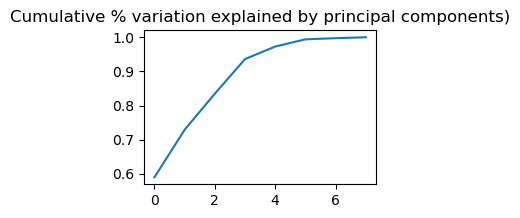

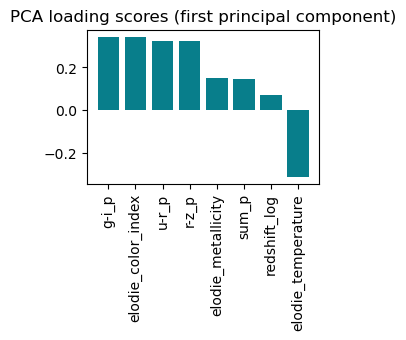

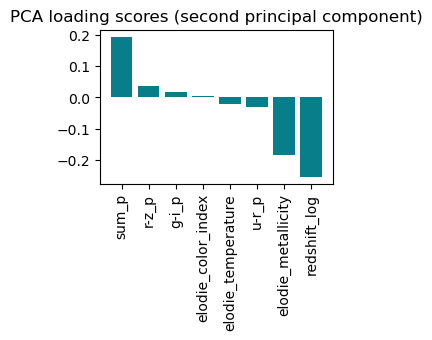


-----X_pca_examples-----


/tmp/ipykernel_7747/971139753.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(class_data['PC1'], class_data['PC2'], label=f'Class {label_name}', cmap='viridis', s=1, alpha=0.5)


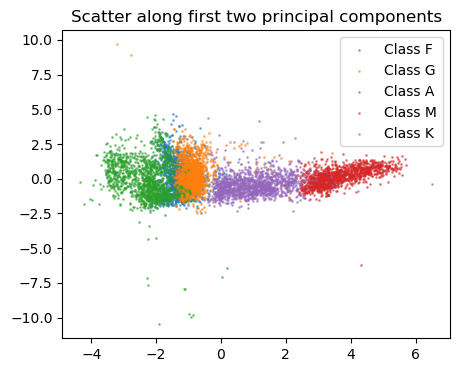

/tmp/ipykernel_7747/971139753.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  fig.scatter(class_data['PC2'], class_data['PC3'], class_data['PC1'], label=f'Class {label_name}', cmap='viridis', s=3, alpha=0.4)


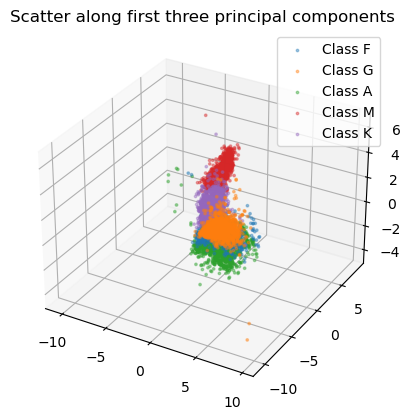

'print(X_pca_examples.shape)\ndisplay(X_pca_examples.head(5))'

In [23]:
# fiting all object_features to a model -- PCA

# setup principal component model
pc = PCA(n_components=3)

# decompose data into principal components (return as ndarrays)
model_pc, history_pc = jsm_fit_model(pc, objects, X0_train, y_train, None, None, 'save')
X7_train = model_pc.transform(X0_train)
X7_validation = model_pc.transform(X0_validation)
X7_test = model_pc.transform(X0_test)
print(X7_train.shape)
print(X7_train[0:5,0:5])

# evaluate principal component explained variance and feature loadings
X_pca_loadings = pca_features(X0_train, features)
"""print(X_pca_loadings.shape)
display(X_pca_loadings.head(5))"""

# plot first two principal components to observe underlying structure
print('\n-----X_pca_examples-----')
X_pca_examples = model_examples(X7_train, y_train, class_column)
"""print(X_pca_examples.shape)
display(X_pca_examples.head(5))"""

# Investigate Models for Tabular Data

### model_km: k-means Clustering


	TRAIN SUBSET:
{'Accuracy Score': 0.09597143578461427, 'Precision Score': 0.07738020947630302, 'Recall Score': 0.09597143578461427, 'F1 Score': 0.08555071384982398}
              precision    recall  f1-score   support

           A       0.36      0.45      0.40     27727
           F       0.00      0.00      0.00     27727
           G       0.02      0.02      0.02     27727
           K       0.01      0.00      0.01     27727
           M       0.00      0.00      0.00     27727

    accuracy                           0.10    138635
   macro avg       0.08      0.10      0.09    138635
weighted avg       0.08      0.10      0.09    138635



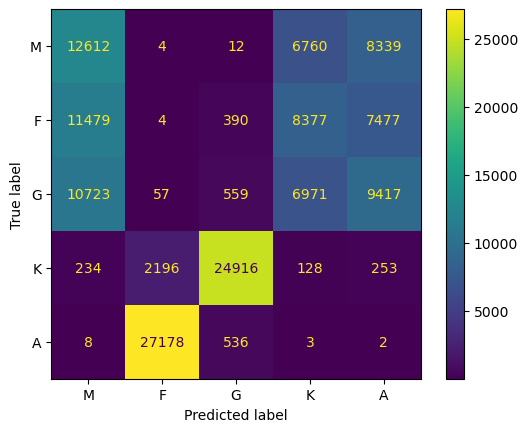


	VALIDATION SUBSET:
{'Accuracy Score': 0.01661399162893995, 'Precision Score': 0.015604028344322323, 'Recall Score': 0.01661399162893995, 'F1 Score': 0.009746287977243856}
              precision    recall  f1-score   support

           A       0.11      0.45      0.17       621
           F       0.00      0.00      0.00      2733
           G       0.01      0.02      0.01      2880
           K       0.03      0.01      0.01      9239
           M       0.00      0.00      0.00      7941

    accuracy                           0.02     23414
   macro avg       0.03      0.09      0.04     23414
weighted avg       0.02      0.02      0.01     23414



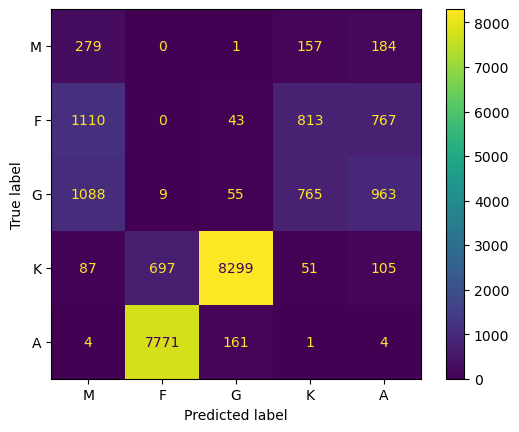

In [24]:
# model as k-means clusters

# setup k-means model
km = KMeans(
    n_clusters=y_train.nunique()[0],
    init='k-means++',
    n_init=10,
    max_iter=300,
    tol=1e-04,
    random_state=38
    )

# fit k-means model
model_km, history_km = jsm_fit_model(km, objects, X7_train, y_train.values.ravel(), None, None, 'save')

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tTRAIN SUBSET:")
jsm_predict(model_km, X7_train, y_train)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_km, X7_validation, y_validation)

### model_dt:  Decision Tree Classifier

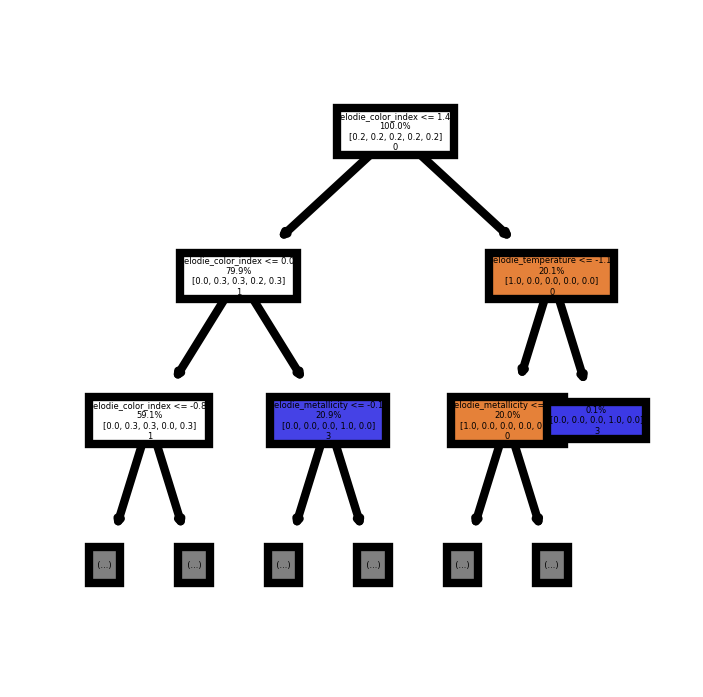


	TRAIN SUBSET:
{'Accuracy Score': 0.9645399790817615, 'Precision Score': 0.9674634434783617, 'Recall Score': 0.9645399790817615, 'F1 Score': 0.9640738568955066}
              precision    recall  f1-score   support

           A       0.98      1.00      0.99     27727
           F       0.99      0.84      0.91     27727
           G       0.87      0.99      0.93     27727
           K       1.00      1.00      1.00     27727
           M       1.00      1.00      1.00     27727

    accuracy                           0.96    138635
   macro avg       0.97      0.96      0.96    138635
weighted avg       0.97      0.96      0.96    138635



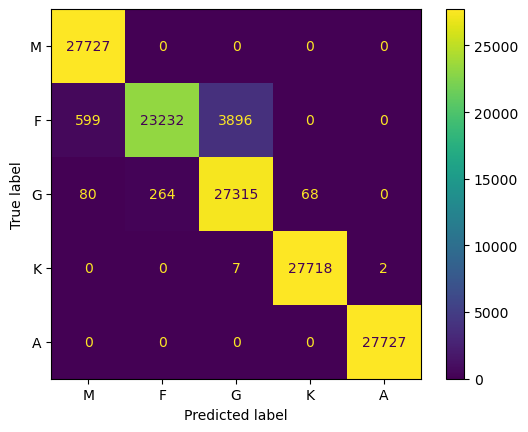


	VALIDATION SUBSET:
{'Accuracy Score': 0.9789015119159478, 'Precision Score': 0.9807294348828378, 'Recall Score': 0.9789015119159478, 'F1 Score': 0.9786424976882065}
              precision    recall  f1-score   support

           A       0.88      1.00      0.94       621
           F       0.99      0.84      0.91      2733
           G       0.88      0.99      0.93      2880
           K       1.00      1.00      1.00      9239
           M       1.00      1.00      1.00      7941

    accuracy                           0.98     23414
   macro avg       0.95      0.96      0.95     23414
weighted avg       0.98      0.98      0.98     23414



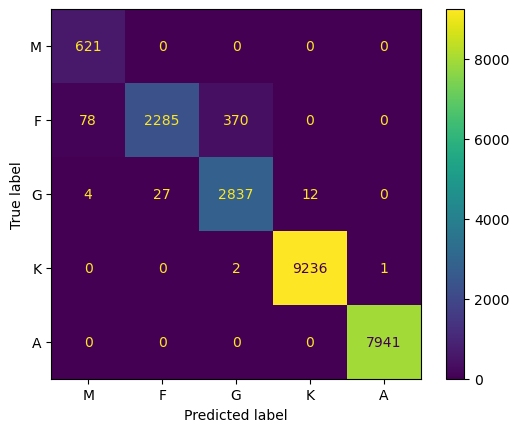

In [25]:
# model as decision tree classifier
 
# setup decision tree model
dt = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=5)#, class_weight = {}#class_weight={0:1.1, 1:1, 2:1.15}, random_state=5)

# fit random forest classifier
model_dt, history_dt = jsm_fit_model(dt, objects, X0_train, y_train, None, None, 'save')
"""dt.fit(X0_train, y_train)"""

# plot decision tree
plt.figure(figsize=(1.25, 1.25), dpi=600)
class_names = sorted(y_train[class_column[0]].unique())
class_names = [str(value) for value in class_names]
tree.plot_tree(model_dt, filled=True, label='none', feature_names=features, class_names=class_names, max_depth=2, proportion=True, impurity=False, precision=1)
#tree.plot_tree(model_dt, filled=True, label='none', feature_names=features, class_names=class_names, max_depth=2, proportion=True, impurity=False, precision=1)
#plt.figure(figsize=(1.25, 1.25), dpi=600)
plt.show()

# make predictions using a model, print performance metrics, then generSate a confusion matrix
print(f"\n\tTRAIN SUBSET:")
jsm_predict(model_dt, X0_train, y_train)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_dt, X0_validation, y_validation)

### model_rf:  Random Forest Classifier


	TRAIN SUBSET:
{'Accuracy Score': 0.936156093338623, 'Precision Score': 0.9358363251918246, 'Recall Score': 0.936156093338623, 'F1 Score': 0.9354821639191804}
              precision    recall  f1-score   support

           A       0.96      0.93      0.94     27727
           F       0.89      0.82      0.85     27727
           G       0.90      0.93      0.91     27727
           K       0.94      0.99      0.97     27727
           M       1.00      1.00      1.00     27727

    accuracy                           0.94    138635
   macro avg       0.94      0.94      0.94    138635
weighted avg       0.94      0.94      0.94    138635



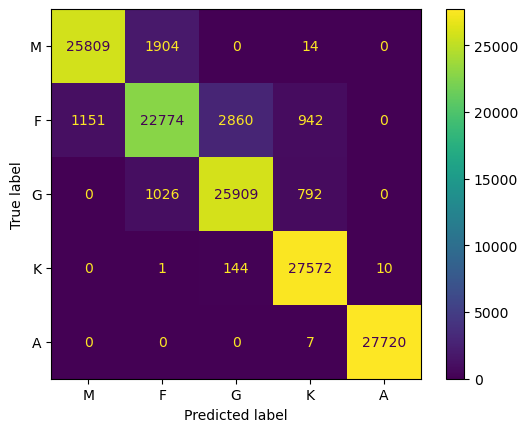


	VALIDATION SUBSET:
{'Accuracy Score': 0.9654053130605621, 'Precision Score': 0.965736448081573, 'Recall Score': 0.9654053130605621, 'F1 Score': 0.9649703898037488}
              precision    recall  f1-score   support

           A       0.81      0.94      0.87       621
           F       0.93      0.82      0.87      2733
           G       0.89      0.92      0.91      2880
           K       0.98      0.99      0.99      9239
           M       1.00      1.00      1.00      7941

    accuracy                           0.97     23414
   macro avg       0.92      0.93      0.93     23414
weighted avg       0.97      0.97      0.96     23414



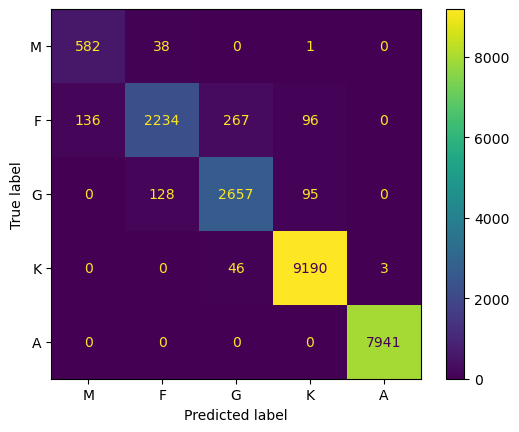

In [26]:
# model as a random forest classifier

# setup random forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=38)

# fit random forest classifier
model_rf, history_rf = jsm_fit_model(rf, objects, X0_train, y_train.values.ravel(), None, None, 'save')

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tTRAIN SUBSET:")
jsm_predict(model_rf, X0_train, y_train)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_rf, X0_validation, y_validation)


### model_knn: K Nearest Neighbors Classifier


	TRAIN SUBSET:
{'Accuracy Score': 0.9945901107224006, 'Precision Score': 0.9945887163526821, 'Recall Score': 0.9945901107224006, 'F1 Score': 0.994587574136058}
              precision    recall  f1-score   support

           A       1.00      1.00      1.00     27727
           F       0.99      0.99      0.99     27727
           G       0.99      0.99      0.99     27727
           K       1.00      1.00      1.00     27727
           M       1.00      1.00      1.00     27727

    accuracy                           0.99    138635
   macro avg       0.99      0.99      0.99    138635
weighted avg       0.99      0.99      0.99    138635



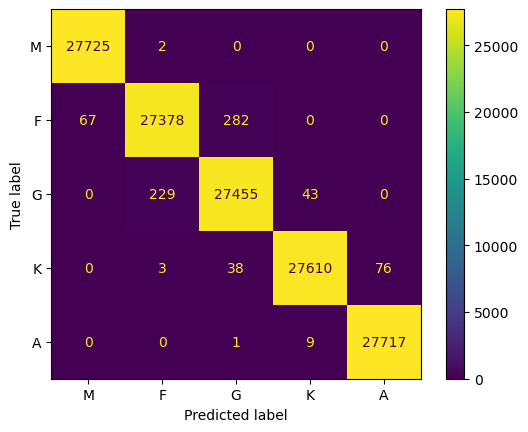


	VALIDATION SUBSET:
{'Accuracy Score': 0.982702656530281, 'Precision Score': 0.9827434775895023, 'Recall Score': 0.982702656530281, 'F1 Score': 0.9826900708992399}
              precision    recall  f1-score   support

           A       0.94      0.98      0.96       621
           F       0.96      0.94      0.95      2733
           G       0.95      0.96      0.95      2880
           K       1.00      0.99      0.99      9239
           M       0.99      1.00      1.00      7941

    accuracy                           0.98     23414
   macro avg       0.97      0.97      0.97     23414
weighted avg       0.98      0.98      0.98     23414



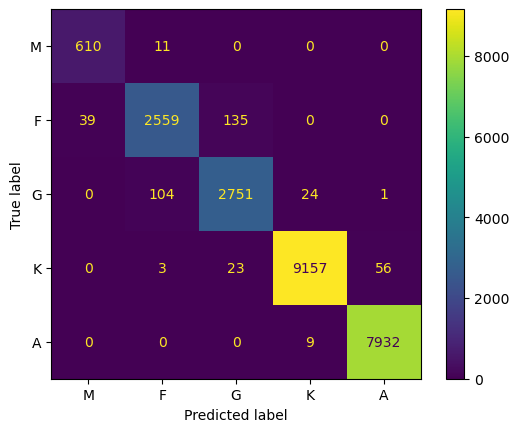

In [27]:
# model as a k nearest neighbors classifier

# setup random forest model
knn = KNeighborsClassifier(n_neighbors=3)

# fit random forest classifier
model_knn, history_knn = jsm_fit_model(knn, objects, X0_train, y_train.values.ravel(), None, None, 'save')

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tTRAIN SUBSET:")
jsm_predict(model_knn, X0_train, y_train)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_knn, X0_validation, y_validation)

### model_mlrc: Multiclass Logistic Regression Classifier

/home/jspencermorris/anaconda3/envs/v_207a/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



	TRAIN SUBSET:
{'Accuracy Score': 0.9091427128791431, 'Precision Score': 0.9088667661576819, 'Recall Score': 0.9091427128791431, 'F1 Score': 0.9089068512950174}
              precision    recall  f1-score   support

           A       0.96      0.99      0.98     27727
           F       0.81      0.79      0.80     27727
           G       0.81      0.82      0.81     27727
           K       0.96      0.98      0.97     27727
           M       1.00      0.97      0.98     27727

    accuracy                           0.91    138635
   macro avg       0.91      0.91      0.91    138635
weighted avg       0.91      0.91      0.91    138635



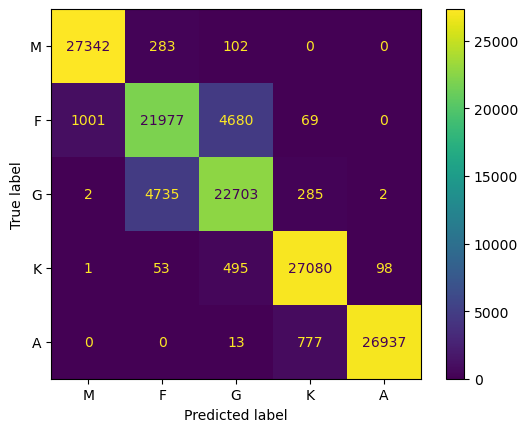


	VALIDATION SUBSET:
{'Accuracy Score': 0.9284616041684463, 'Precision Score': 0.9299459603643045, 'Recall Score': 0.9284616041684463, 'F1 Score': 0.9288953009292625}
              precision    recall  f1-score   support

           A       0.84      0.98      0.90       621
           F       0.80      0.77      0.78      2733
           G       0.77      0.81      0.79      2880
           K       0.97      0.97      0.97      9239
           M       0.99      0.97      0.98      7941

    accuracy                           0.93     23414
   macro avg       0.87      0.90      0.89     23414
weighted avg       0.93      0.93      0.93     23414



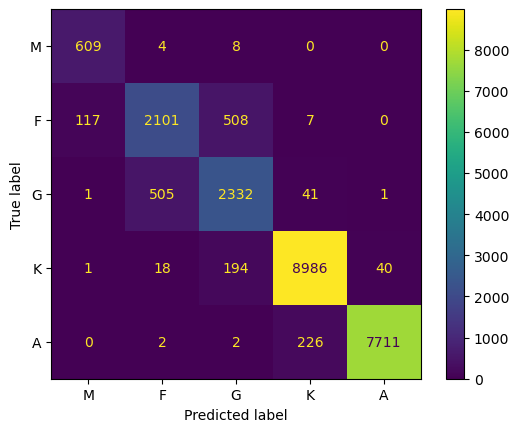

In [28]:
# model as a multiclass logistic regression classifier

# setup multiclass logistic regression model
mlrc = LogisticRegression(max_iter=10000, class_weight='balanced', solver='lbfgs', multi_class='ovr')

# fit multiclass logistic regression classifier
model_mlrc, history_mlrc = jsm_fit_model(mlrc, objects, X0_train, y_train, None, None, 'save')

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tTRAIN SUBSET:")
jsm_predict(model_mlrc, X0_train, y_train)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_mlrc, X0_validation, y_validation)

### model_mlp: Multilayer Perceptron Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2304      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 35,845
Trainable params: 35,845
Non-trainable params: 0
_________________________________________________________________


2023-11-29 02:29:43.170467: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


None
Epoch 1/5
68/68 [==============================] - 3s 31ms/step - loss: 0.2953 - accuracy: 0.8860 - val_loss: 0.0977 - val_accuracy: 0.9732
Epoch 2/5
68/68 [==============================] - 2s 28ms/step - loss: 0.0965 - accuracy: 0.9702 - val_loss: 0.0750 - val_accuracy: 0.9806
Epoch 3/5
68/68 [==============================] - 2s 28ms/step - loss: 0.0661 - accuracy: 0.9805 - val_loss: 0.0467 - val_accuracy: 0.9868
Epoch 4/5
68/68 [==============================] - 2s 26ms/step - loss: 0.0518 - accuracy: 0.9853 - val_loss: 0.0413 - val_accuracy: 0.9880
Epoch 5/5
68/68 [==============================] - 2s 26ms/step - loss: 0.0472 - accuracy: 0.9858 - val_loss: 0.0345 - val_accuracy: 0.9900


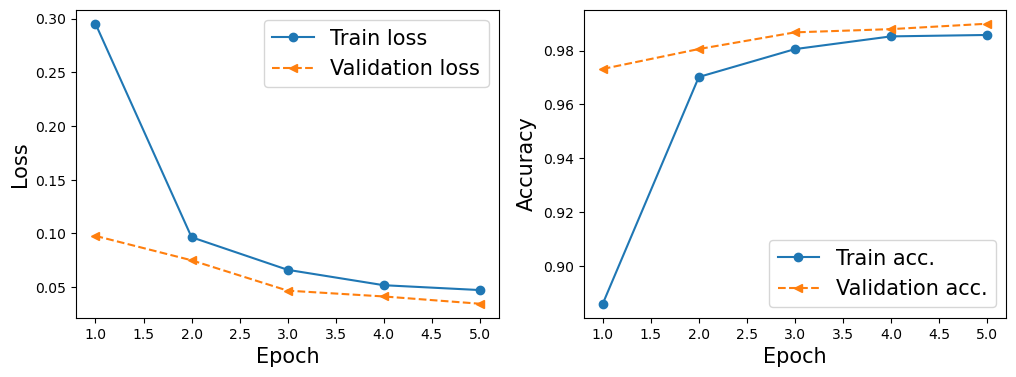


	TRAIN SUBSET:
4333/4333 [==============================] - 21s 5ms/step
{'Accuracy Score': 0.9867349514913262, 'Precision Score': 0.9867939294643987, 'Recall Score': 0.9867349514913262, 'F1 Score': 0.9867510150348809}
              precision    recall  f1-score   support

           A       0.99      0.98      0.99     27727
           F       0.97      0.98      0.97     27727
           G       0.98      0.98      0.98     27727
           K       0.99      1.00      1.00     27727
           M       1.00      1.00      1.00     27727

    accuracy                           0.99    138635
   macro avg       0.99      0.99      0.99    138635
weighted avg       0.99      0.99      0.99    138635



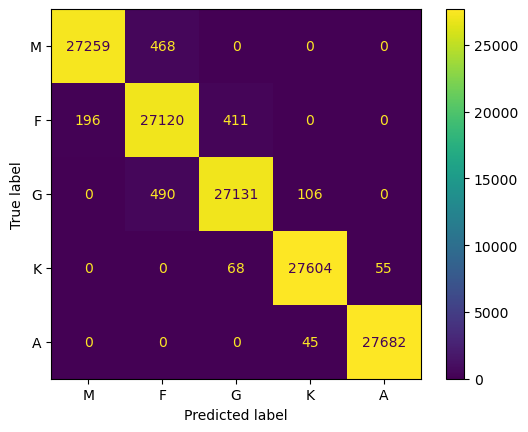


	VALIDATION SUBSET:
732/732 [==============================] - 3s 4ms/step
{'Accuracy Score': 0.9899632698385581, 'Precision Score': 0.9899942979914252, 'Recall Score': 0.9899632698385581, 'F1 Score': 0.9899708862794458}
              precision    recall  f1-score   support

           A       0.95      0.98      0.96       621
           F       0.97      0.97      0.97      2733
           G       0.98      0.97      0.98      2880
           K       1.00      0.99      1.00      9239
           M       1.00      1.00      1.00      7941

    accuracy                           0.99     23414
   macro avg       0.98      0.98      0.98     23414
weighted avg       0.99      0.99      0.99     23414



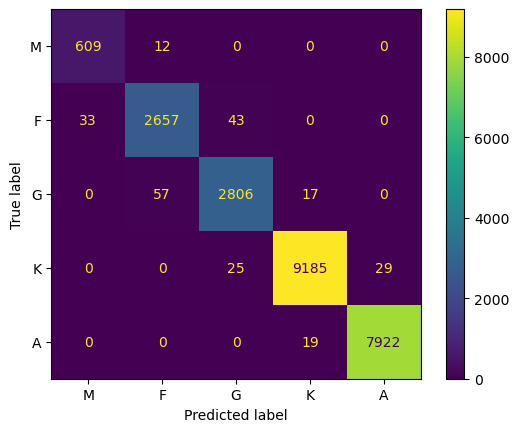

In [29]:
# model as a multiclass logistic regression classifier
# NOTE: using two hidden layers

# setup multiclass logistic regression model
mlp = keras.Sequential([
    layers.Dense(
        units=256   ,              # output dim
        input_shape=[X_train.shape[1]],             # input dim
        use_bias=True,                              # we included the bias in X
        activation='relu',                          # apply a sigmoid to the output
        kernel_initializer='random_normal',         # initialize params to small random numbers
        bias_initializer='zeros'                    # initialize biases to 0
    ),
    layers.Dense(
        units=128,                                  # output dim
        use_bias=True,                              # we included the bias in X
        activation='relu',                          # apply a sigmoid to the output
        kernel_initializer='random_normal',         # initialize params to small random numbers
        bias_initializer='zeros'                    # initialize biases to 0
    ),
    layers.Dense(
        units=y_train.nunique()[0],                 # output dim
        use_bias=True,                              # we included the bias in X
        activation='softmax',                       # apply a sigmoid to the output
        kernel_initializer='random_normal',         # initialize params to small random numbers
        bias_initializer='zeros'                    # initialize biases to 0
    )
])
print(mlp.summary())
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
mlp.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# fit multiclass logistic regression classifier
model_mlp, history_mlp = jsm_fit_model(mlp, objects, X0_train, y_train, X0_validation, y_validation, 'save', epochs=5, batch_size=2048, verbose=1) # quick training:  epochs=3, batch_size=65536, verbose=1

# plot performance history
jsm_plot_history(history_mlp)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tTRAIN SUBSET:")
jsm_predict(model_mlp, X0_train, y_train)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_mlp, X0_validation, y_validation)

# Summarization of Results